In [72]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.model_selection import FeatureImportances
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from bcb import sgs
from tsfresh import extract_features, select_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
import joblib
from sklearn.datasets import load_iris
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import  ClassBalance,DiscriminationThreshold
from lime import lime_tabular
from sklearn.base import BaseEstimator, ClassifierMixin
from scikitplot.metrics import plot_roc, plot_precision_recall


In [73]:
ativos = ["BTC-USD"]
df = yf.download(ativos, start="2005-01-01")
index = df.index
dfs = yf.download('^GSPC', start="2005-01-01")
dfg = pd.re
# dvix = yf.download('^VIX',start="2000-01-01")

# df["retorno"] = df["Close"].pct_change()
# df["retorno shifted"] = df["Close"].pct_change().shift(-1)
# dfs["retorno"] = dfs["Adj Close"].pct_change()
# df["vix pct"] = dvix["Close"].pct_change()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [74]:
# def get_tsfresh_features(df):
#     # Get statistic features using library TSFRESH 
#     # Thanks to https://www.kaggle.com/code/vbmokin/btc-growth-forecasting-with-advanced-fe-for-ohlc
    
#     df = df.reset_index(drop=False).reset_index(drop=False)
    
#     # Extract features
#     extracted_features = extract_features(df, column_id="Date", column_sort="Date")
    
#     # Drop features with NaN
#     extracted_features_clean = extracted_features.dropna(axis=1, how='all').reset_index(drop=True)
    
#     # Drop features with constants
#     cols_std_zero  = []
#     for col in extracted_features_clean.columns:
#         if extracted_features_clean[col].std()==0:
#             cols_std_zero.append(col)
#     extracted_features_clean = extracted_features_clean.drop(columns = cols_std_zero)

#     # extracted_features_clean['Date'] = df["Date"]   # For the merging
    
#     return extracted_features_clean

In [75]:
# %%time
# # FE with TSFRESH
# extracted_features_clean = get_tsfresh_features(df[['Close']])



In [76]:
# Extracted features by TSFRESH with cleaning
# extracted_features_clean.columns.tolist()

In [77]:
# # Get all features
# df = pd.merge(df, extracted_features_clean, how='left', on=df.index)


In [78]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-08-25,26163.679688,26248.103516,25786.812500,26047.667969,26047.667969,12406045118
2023-08-26,26047.234375,26107.384766,25983.878906,26008.462891,26008.462891,6034817316
2023-08-27,26008.242188,26165.373047,25965.097656,26089.693359,26089.693359,6913768611


In [79]:
# df = df.drop(columns='key_0')

In [80]:
df = df.set_index(index, inplace=False)

In [81]:
df["retorno"] = df["Close"].pct_change()
# df["retorno shifted"] = df["Close"].pct_change().shift(-1)
dfs["retorno"] = dfs["Adj Close"].pct_change()
# df['vix'] = dvix["Close"]
# df['pct vix'] = df['vix'].pct_change()


In [82]:
df = df.dropna()
dfs = dfs.dropna()

In [83]:
df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()

In [84]:
cdi = sgs.get({'CDI':12}, start='1970-01-01')
ipca = sgs.get({'IPCA':433}, start='2005-01-01')

In [85]:
df["ipca"] = ipca

In [86]:
df["ipca"] = ipca
df["ipca"] = df["ipca"].fillna(0)
valor = None
for i in range(len(df)):
    if(df["ipca"].iloc[i] != 0):
        valor = df["ipca"].iloc[i]
    elif(df["ipca"].iloc[i] == 0):
        df["ipca"].iloc[i] = valor 

c:\Python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [87]:
df["cdi"] = cdi
df["cdi"] = df["cdi"].fillna(0)
valor = None
for i in range(len(df)):
    if(df["cdi"].iloc[i] != 0):
        valor = df["cdi"].iloc[i]
    elif(df["cdi"].iloc[i] == 0):
        df["cdi"].iloc[i] = valor 

In [88]:
df["cdi"] = cdi/100

In [89]:
df = df.dropna()

In [90]:
vetor = list([])
for i in range(len(df)-1):
    if (i == len(df)):
        vetor.append(0)
    elif (df["Adj Close"].iloc[i+1]  <  df["Adj Close"].iloc[i]):
        vetor.append(0)
    elif (df["Adj Close"].iloc[i+1]  >  df["Adj Close"].iloc[i]): 
        vetor.append(1)
    else:
        vetor.append(0)

In [91]:
df = df.drop(df.index[0])
df['signal'] = pd.array(vetor).shift(-1)
df = df.dropna()


In [92]:
# df = df.drop(columns=['index__sum_values',
#  'index__abs_energy',
#  'index__median',
#  'index__mean',
#  'index__root_mean_square',
#  'index__maximum',
#  'index__absolute_maximum',
#  'index__minimum',
#  'index__benford_correlation',
#  'index__quantile__q_0.1',
#  'index__quantile__q_0.2',
#  'index__quantile__q_0.3',
#  'index__quantile__q_0.4',
#  'index__quantile__q_0.6',
#  'index__quantile__q_0.7',
#  'index__quantile__q_0.8',
#  'index__quantile__q_0.9',
#  'index__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)',
#  'index__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)',
#  'index__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)',
#  'index__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)',
#  'index__fft_coefficient__attr_"real"__coeff_0',
#  'index__fft_coefficient__attr_"abs"__coeff_0',
#  'index__value_count__value_0',
#  'index__value_count__value_1',
#  'index__range_count__max_1__min_-1',
#  'index__count_below__t_0'])

In [93]:
df["hlco ratio"] = ((df['High'] - df['Low'])/(df['Close']-df['Open'])).replace([np.inf, -np.inf, np.nan], 0.)
df['Upper_Shadow'] = df['High'] - np.maximum(df['Close'], df['Open'])
df['Lower_Shadow'] = np.minimum(df['Close'], df['Open']) - df['Low']
df['high2low'] = (df['High'] / df['Low']).replace([np.inf, -np.inf, np.nan], 0.)

In [94]:
Y = df[df.index < "2022-01-01"]["signal"]
X = df[df.index < "2022-01-01"].loc[:, (df.columns != "signal")&(df.columns != "retorno")]

X = pd.DataFrame(X)
Y = Y.astype('int')
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)

GridSearch 

In [95]:
class CustomThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier, threshold=0.5):
        self.base_classifier = base_classifier
        self.threshold = threshold

    def fit(self, X, y):
        self.base_classifier.fit(X, y)
        return self

    def predict(self, X):
        prob_pos = self.base_classifier.predict_proba(X)[:, 1]
        return np.where(prob_pos > self.threshold, 1, 0)

In [96]:
rf = RandomForestClassifier(max_features='sqrt',random_state=42, n_estimators = 150, min_samples_leaf=2, min_samples_split=10, oob_score=True,bootstrap=True)#, criterion='entropy')

In [97]:
# Criar o modelo personalizado com limiar ajustado
custom_model = CustomThresholdClassifier(base_classifier=rf, threshold=0.57)

In [98]:
# param_grid = {
#     'n_estimators': [150, 350, 400],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_depth': [None, 10, 20], 
#     'max_leaf_nodes': [None, 10, 20],
#     'random_state': [42, 2021, None] 
# }


In [99]:


# grid_search = GridSearchCV(
#     rf, param_grid, cv=5,
#     scoring='recall',  # Use appropriate scoring metric for binary classification
#     return_train_score=True
# )


In [100]:
# grid_search.fit(x_train, y_train)
# grid_search.best_params_

In [101]:
# grid_search.best_estimator_

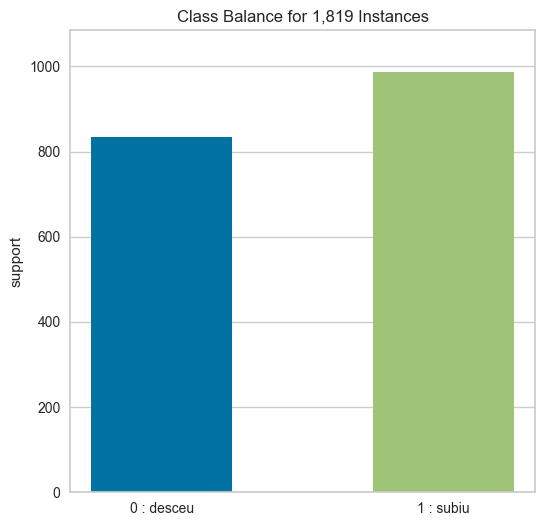

<AxesSubplot:title={'center':'Class Balance for 1,819 Instances'}, ylabel='support'>

In [102]:
fig, ax = plt.subplots(figsize=(6,6))
cb_viz = ClassBalance(labels=["0 : desceu", "1 : subiu"])
cb_viz.fit(Y)
cb_viz.poof()

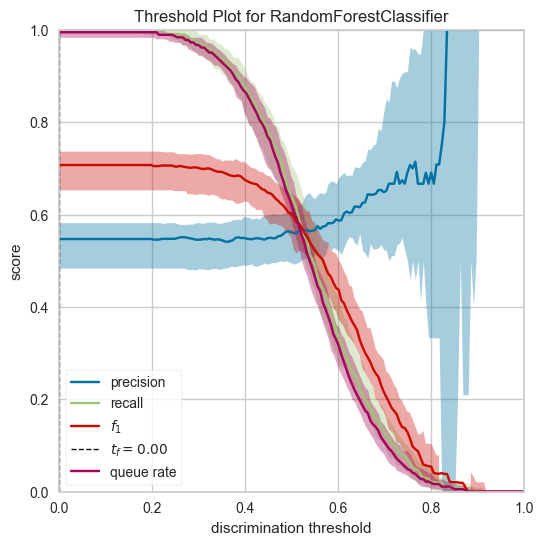

<AxesSubplot:title={'center':'Threshold Plot for RandomForestClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [103]:
fig, ax =plt.subplots(figsize=(6,6))
dt_viz = DiscriminationThreshold(rf)
dt_viz.fit(X,Y)
dt_viz.poof()

Random forests application

In [104]:

rf.fit(x_train,y_train)
predictrftest = rf.predict(x_test)
print(classification_report(y_test, predictrftest))

              precision    recall  f1-score   support

           0       0.50      0.46      0.48       250
           1       0.58      0.61      0.59       296

    accuracy                           0.55       546
   macro avg       0.54      0.54      0.54       546
weighted avg       0.54      0.55      0.54       546



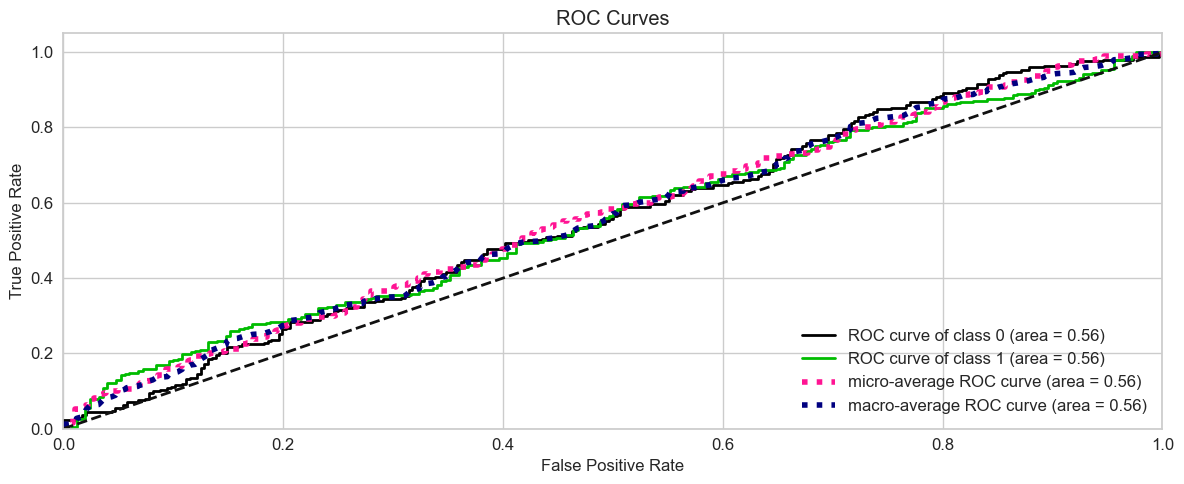

In [105]:
# Prever probabilidades
y_prob = rf.predict_proba(x_test)

# Plotar as curvas ROC 
plot_roc(y_test, y_prob, title='ROC Curves', figsize=(12, 5))


plt.tight_layout()
plt.show()

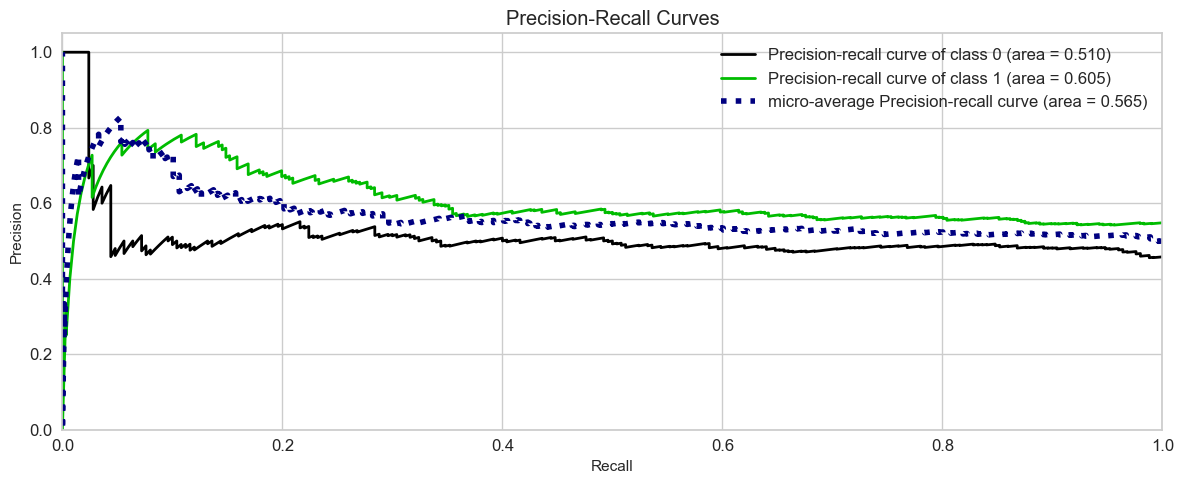

In [106]:
#plotar Precision-Recall
plot_precision_recall(y_test, y_prob, title='Precision-Recall Curves', figsize=(12, 5))

plt.tight_layout()
plt.show()

In [107]:
explainer = lime_tabular.LimeTabularExplainer(x_train.values, feature_names=X.columns, class_names=["desceu", "subiu"])
exp = explainer.explain_instance(x_train.iloc[-1].values, rf.predict_proba)
exp.show_in_notebook()
# exp.as_pyplot_figure()

c:\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [108]:
# model_filename = 'random_forest_model.joblib'
# joblib.dump(rf, model_filename)

In [109]:
# rf = joblib.load('random_forest_model.joblib')


c:\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


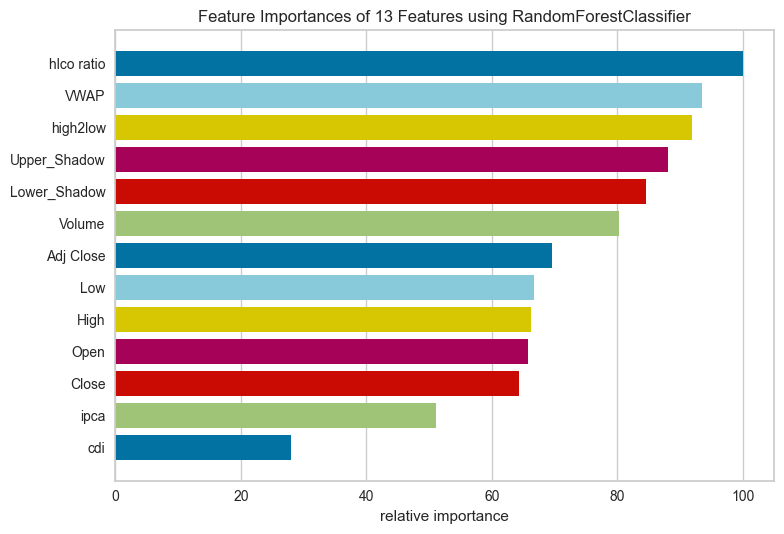

<AxesSubplot:title={'center':'Feature Importances of 13 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [110]:
viz = FeatureImportances(rf)
fig, ax = plt.subplots()
viz = FeatureImportances(rf, relative=True) 
viz.fit(x_train, y_train)
viz.poof()

In [111]:
df_aux = df[df.index >= "2022-01-01"]
dfs_aux = dfs[dfs.index >= '2022-01-01']

In [112]:
K = df_aux["signal"]
Z = df_aux.loc[:, (df_aux.columns != "signal")&(df_aux.columns != "retorno")]

In [113]:
df_aux["sinal modelo"] = custom_model.predict(Z)

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [114]:
df_aux["sinal modelo"].value_counts()

0    398
1     17
Name: sinal modelo, dtype: int64

In [115]:
rent = list([])
for i in range(len(df_aux)):
    if (df_aux["sinal modelo"].iloc[i-1] == 1):
        rent.append(df_aux["retorno"].iloc[i] - 0.00009)
    elif (df_aux["sinal modelo"].iloc[i-1] == 0):
        rent.append(-df_aux["retorno"].iloc[i]-0.00018 +2*df_aux["cdi"].iloc[i])

In [116]:
df_aux["retorno estrategia"] = rent

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


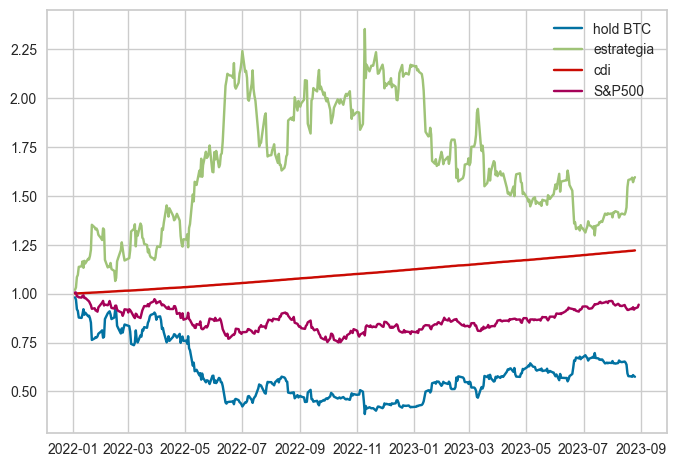

In [117]:
plt.plot(df_aux.index, (df_aux["retorno"]+1).cumprod(), label="hold BTC")
plt.plot(df_aux.index, (df_aux["retorno estrategia"]+1).cumprod(), label="estrategia")
plt.plot(df_aux.index, (df_aux["cdi"]+1).cumprod(), label='cdi')
plt.plot((dfs_aux["retorno"]+1).cumprod(), label='S&P500')
plt.legend()


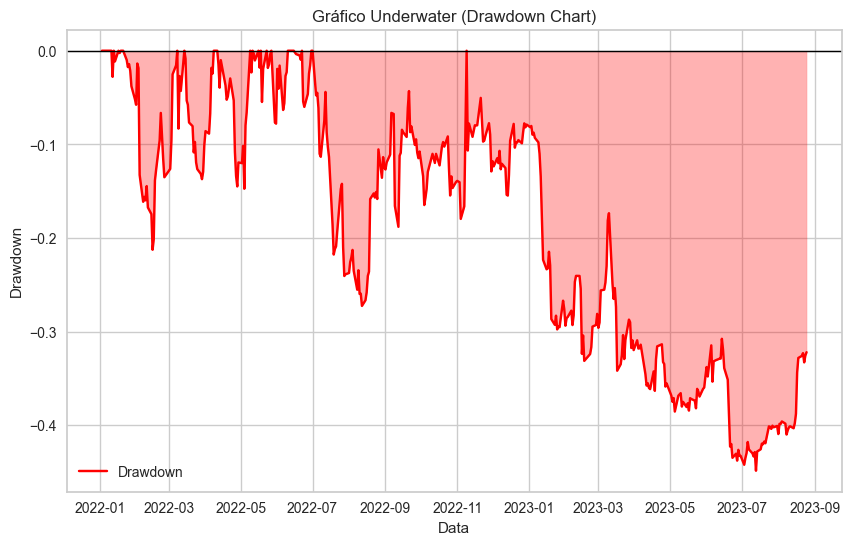

In [118]:
rolling_max = (df_aux['retorno estrategia']+1).cumprod().cummax()
drawdown = ((df_aux['retorno estrategia']+1).cumprod() / rolling_max)  -1

# Plotar o gráfico Underwater
plt.figure(figsize=(10, 6))
plt.plot(df_aux.index, drawdown, color='red', label='Drawdown')
plt.fill_between(df_aux.index, drawdown, color='red', alpha=0.3)
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('Data')
plt.ylabel('Drawdown')
plt.title('Gráfico Underwater (Drawdown Chart)')
plt.legend()
plt.grid(True)
plt.show()

In [119]:
df_aux["excessos retorno"] = df_aux["retorno estrategia"] - df_aux["cdi"]
sharpe_ratio_diario = df_aux["excessos retorno"].mean() / df_aux["excessos retorno"].std()
sharpe_ratio_diario

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0.035973831817879304

In [120]:
# Calcular o beta
covariance = np.cov((df_aux['retorno estrategia']-df_aux["cdi"]), (df_aux['retorno'] - df_aux['cdi']))[0][1]
variance_market = np.var(df_aux['retorno']-df_aux['cdi'])

beta = covariance / variance_market

print("Beta da estratégia em relação ao BTC:", beta)

Beta da estratégia em relação ao BTC: -0.9532510667810439


(array([ 1.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  1.,  1.,
         1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  2.,  4.,  3.,  2.,  6.,
         1.,  3.,  4.,  3.,  5.,  6., 13.,  8.,  9., 12., 12., 14.,  9.,
        18., 26., 18., 23., 22., 24., 26., 16., 17.,  9., 11.,  8.,  7.,
         5., 13.,  8.,  3.,  2.,  2.,  2.,  3.,  4.,  1.,  2.,  0.,  4.,
         1.,  1.,  1.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         2.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([-1.16354706e-01, -1.13586031e-01, -1.10817355e-01, -1.08048680e-01,
        -1.05280004e-01, -1.02511329e-01, -9.97426533e-02, -9.69739779e-02,
        -9.42053024e-02, -9.14366269e-02, -8.86679515e-02, -8.58992760e-02,
        -8.31306005e-02, -8.03619251e-02, -7.75932496e-02, -7.48245741e-02,
        -7.20558987e-02, -6.92872232e-02, -6.65185478e-02, -6.37498723e-02,
        -6.09811968e-02, -5.82125214e-02, -5.54438459e

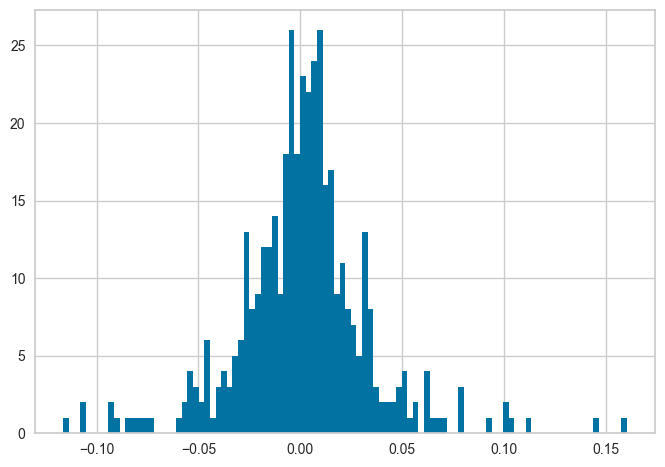

In [121]:
plt.hist(df_aux["retorno estrategia"], bins=100)

In [122]:
bin_edges = np.histogram_bin_edges(df_aux["retorno estrategia"], bins=50)
hist = np.histogram(df_aux["retorno estrategia"])
bin_edges
hist

(array([  6,   5,  29, 106, 192,  53,  14,   7,   1,   2], dtype=int64),
 array([-0.11635471, -0.08866795, -0.0609812 , -0.03329444, -0.00560769,
         0.02207907,  0.04976582,  0.07745258,  0.10513933,  0.13282609,
         0.16051284]))

In [123]:
# Seus dados de retorno de estratégia
retorno_estrategia = df_aux["retorno estrategia"]

# Calculando os bin edges
bin_edges = np.histogram_bin_edges(retorno_estrategia, bins=50)

# Calculando o histograma
hist, _ = np.histogram(retorno_estrategia, bins=bin_edges)

# Valor a partir do qual você quer contar
valor_referencia = 0

# Encontre o índice do bin a partir do qual você deseja contar
indice_bin_referencia = next(idx for idx, edge in enumerate(bin_edges) if edge > valor_referencia)

# Conte as observações nos bins à direita do valor de referência
observacoes_direita = sum(hist[indice_bin_referencia:])

print(f"Observações à direita de {valor_referencia}: {observacoes_direita}")

Observações à direita de 0: 180


In [124]:
# Seus dados de retorno de estratégia
retorno_estrategia = df_aux["retorno estrategia"]

# Calculando os bin edges
bin_edges = np.histogram_bin_edges(retorno_estrategia, bins=50)

# Calculando o histograma
hist, _ = np.histogram(retorno_estrategia, bins=bin_edges)

# Valor a partir do qual você quer contar
valor_referencia = 0

# Encontre o índice do bin até o qual você deseja contar
indice_bin_referencia = next(idx for idx, edge in enumerate(bin_edges) if edge > valor_referencia)

# Conte as observações nos bins à esquerda do valor de referência
observacoes_esquerda = sum(hist[:indice_bin_referencia])

print(f"Observações à esquerda de {valor_referencia}: {observacoes_esquerda}")


Observações à esquerda de 0: 235


In [125]:
# Separar retornos positivos e negativos
retornos_positivos = df_aux[df_aux['retorno estrategia'] > 0]['retorno estrategia']

retornos_negativos = df_aux[df_aux['retorno estrategia'] < 0]['retorno estrategia']

# Calcular a diferença entre os retornos positivos e negativos
diferenca_retornos = np.sum(retornos_positivos) + np.sum(retornos_negativos)

print(f"Diferença entre retornos positivos e negativos: {diferenca_retornos}")

Diferença entre retornos positivos e negativos: 0.6850602047134311


(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  2.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  3.,  0.,  0.,  1.,  1.,  1.,  4.,  1.,  2.,  0.,
         5.,  2.,  2.,  2.,  2.,  4.,  6., 12.,  6.,  9.,  9., 11.,  8.,
        13., 14., 27., 23., 26., 22., 17., 25., 18.,  9., 15., 14., 14.,
        10.,  7., 12.,  5.,  6.,  3.,  3.,  4.,  1.,  6.,  3.,  3.,  4.,
         1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
         2.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  1.]),
 array([-0.15974726, -0.15698001, -0.15421275, -0.1514455 , -0.14867825,
        -0.14591099, -0.14314374, -0.14037649, -0.13760923, -0.13484198,
        -0.13207473, -0.12930747, -0.12654022, -0.12377297, -0.12100571,
        -0.11823846, -0.11547121, -0.11270395, -0.1099367 , -0.10716945,
        -0.1044022 , -0.10163494, -0.09886769, -0.09610044, -0.09333318,
        -0.09056593, -0.08779868, -0.08503142, -0.08226417, -0.079496

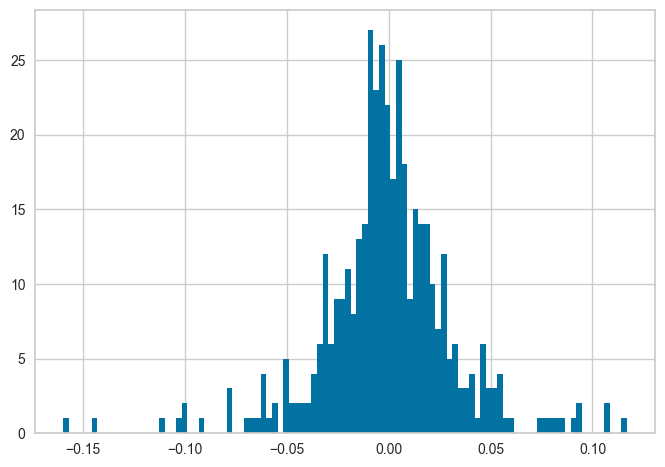

In [126]:
plt.hist(df_aux["retorno"],bins=100)

In [127]:
bin_edges = np.histogram_bin_edges(df_aux["retorno"], bins=50)
hist = np.histogram(df_aux["retorno"])
bin_edges
hist

(array([  2,   1,   7,  15,  54, 186, 110,  29,   5,   6], dtype=int64),
 array([-0.15974726, -0.13207473, -0.1044022 , -0.07672966, -0.04905713,
        -0.0213846 ,  0.00628794,  0.03396047,  0.061633  ,  0.08930553,
         0.11697807]))

In [128]:
# Seus dados de retorno de estratégia
retorno_estrategia = df_aux["retorno"]

# Calculando os bin edges
bin_edges = np.histogram_bin_edges(retorno_estrategia, bins=50)

# Calculando o histograma
hist, _ = np.histogram(retorno_estrategia, bins=bin_edges)

# Valor a partir do qual você quer contar
valor_referencia = 0

# Encontre o índice do bin a partir do qual você deseja contar
indice_bin_referencia = next(idx for idx, edge in enumerate(bin_edges) if edge > valor_referencia)

# Conte as observações nos bins à direita do valor de referência
observacoes_direita = sum(hist[indice_bin_referencia:])

print(f"Observações à direita de {valor_referencia}: {observacoes_direita}")


Observações à direita de 0: 192


In [129]:
# Seus dados de retorno de estratégia
retorno_estrategia = df_aux["retorno"]

# Calculando os bin edges
bin_edges = np.histogram_bin_edges(retorno_estrategia, bins=50)

# Calculando o histograma
hist, _ = np.histogram(retorno_estrategia, bins=bin_edges)

# Valor a partir do qual você quer contar
valor_referencia = 0

# Encontre o índice do bin até o qual você deseja contar
indice_bin_referencia = next(idx for idx, edge in enumerate(bin_edges) if edge > valor_referencia)

# Conte as observações nos bins à esquerda do valor de referência
observacoes_esquerda = sum(hist[:indice_bin_referencia])

print(f"Observações à esquerda de {valor_referencia}: {observacoes_esquerda}")

Observações à esquerda de 0: 223


In [130]:
# Separar retornos positivos e negativos
retornos_positivos = df_aux[df_aux['retorno'] > 0]['retorno']

retornos_negativos = df_aux[df_aux['retorno'] < 0]['retorno']

# Calcular a diferença entre os retornos positivos e negativos
diferenca_retornos = np.sum(retornos_positivos) + np.sum(retornos_negativos)

print(f"Diferença entre retornos positivos e negativos: {diferenca_retornos}")

Diferença entre retornos positivos e negativos: -0.331751165626498


In [131]:
# Calcular o alfa
average_return_btc = df_aux['retorno estrategia']
average_return_market = df_aux['retorno']
alpha = np.mean(average_return_btc) - beta * np.mean(average_return_market)

print("Alfa da estratégia em relação ao BTC-USD:", alpha)

Alfa da estratégia em relação ao BTC-USD: 0.0008887181980099181


In [132]:
predict = rf.predict(Z[Z.index > '2022-10-08'])
predict = pd.DataFrame(predict)
predict.index = df_aux[df_aux.index > '2022-10-08'].index
predict.columns = ['sinal']

In [133]:
predict.value_counts()

sinal
0        191
1         30
dtype: int64

In [134]:
rent = list([])
for i in range(len(predict)):
    if (predict['sinal'].iloc[i-1] == 1):
        rent.append(df_aux[df_aux.index > '2022-10-08']["retorno"].iloc[i] - 0.00009)
    elif (predict['sinal'].iloc[i-1] == 0):
        rent.append(-df_aux[df_aux.index > '2022-10-08']["retorno"].iloc[i]-0.00018 +2*df_aux[df_aux.index > '2022-10-08']["cdi"].iloc[i])

In [135]:
retorno_estrategia = np.array(rent)

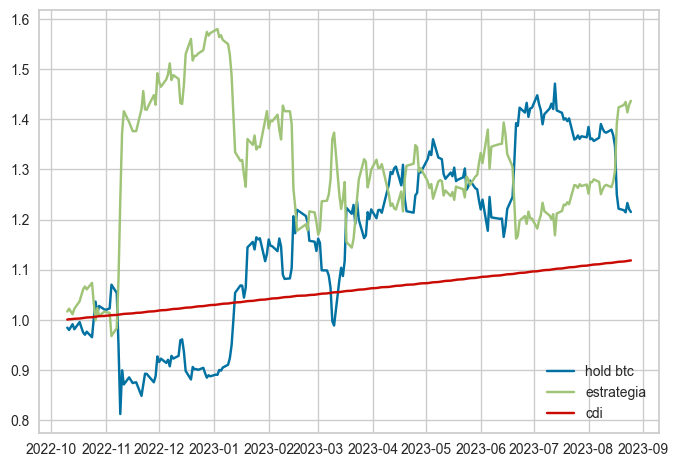

In [136]:
plt.plot(predict.index, (df_aux[df_aux.index > '2022-10-08']["retorno"]+1).cumprod(), label="hold btc")
plt.plot(predict.index, (retorno_estrategia+1).cumprod(), label="estrategia")
plt.plot(predict.index, (df_aux[df_aux.index > '2022-10-08']["cdi"]+1).cumprod(), label='cdi')
# plt.plot(predict.index,(dfs_aux[dfs_aux.index > '2022-10-08']["retorno"]+1).cumprod(), label='S&P500')
plt.legend()

In [137]:
predict = rf.predict(Z[Z.index > '2023-05-01'])
predict = pd.DataFrame(predict)
predict.index = df_aux[df_aux.index > '2023-05-01'].index
predict.columns = ['sinal']

In [138]:
rent = list([])
for i in range(len(predict)):
    if (predict['sinal'].iloc[i-1] == 1):
        rent.append(df_aux[df_aux.index > '2023-05-01']["retorno"].iloc[i] - 0.00009)
    elif (predict['sinal'].iloc[i-1] == 0):
        rent.append(-df_aux[df_aux.index > '2023-05-01']["retorno"].iloc[i]-0.00018 +2*df_aux[df_aux.index > '2023-05-01']["cdi"].iloc[i])

In [139]:
retorno_estrategia = np.array(rent)

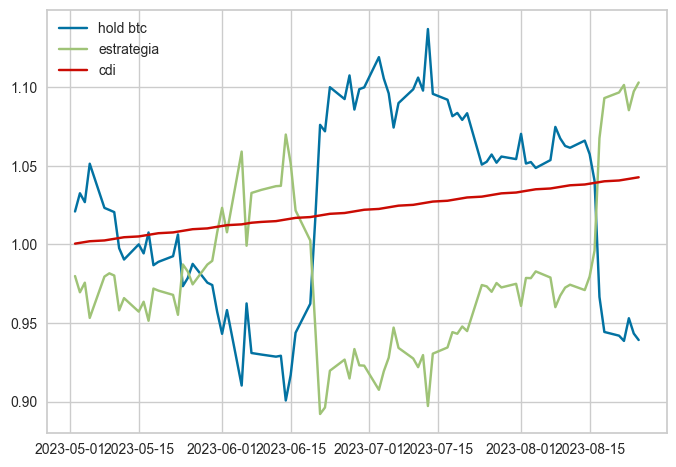

In [140]:
plt.plot(predict.index, (df_aux[df_aux.index > '2023-05-01']["retorno"]+1).cumprod(), label="hold btc")
plt.plot(predict.index, (retorno_estrategia+1).cumprod(), label="estrategia")
plt.plot(predict.index, (df_aux[df_aux.index > '2023-05-01']["cdi"]+1).cumprod(), label='cdi')
# plt.plot(predict.index,(dfs_aux[dfs_aux.index > '2022-10-08']["retorno"]+1).cumprod(), label='S&P500')
plt.legend()

In [141]:
# Y = pd.DataFrame(Y)
# Y

In [142]:
# tree_accuracies = []
# for tree in rf.estimators_:
#     y_pred = tree.predict(x_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     tree_accuracies.append(accuracy)

# # Identificar a árvore de maior precisão
# best_tree_index = tree_accuracies.index(max(tree_accuracies))
# best_tree = rf.estimators_[best_tree_index]

# # Exportar a árvore para visualização
# dot_data = export_graphviz(best_tree, out_file=None,
#                            feature_names=X.columns,
#                            class_names=['Classe 0', 'Classe 1'],
#                            filled=True, rounded=True,
#                            special_characters=True)
# graph = graphviz.Source(dot_data)
# graph.render('best_tree', format='png')  # Isso salvará a árvore em um arquivo
# graph.view()